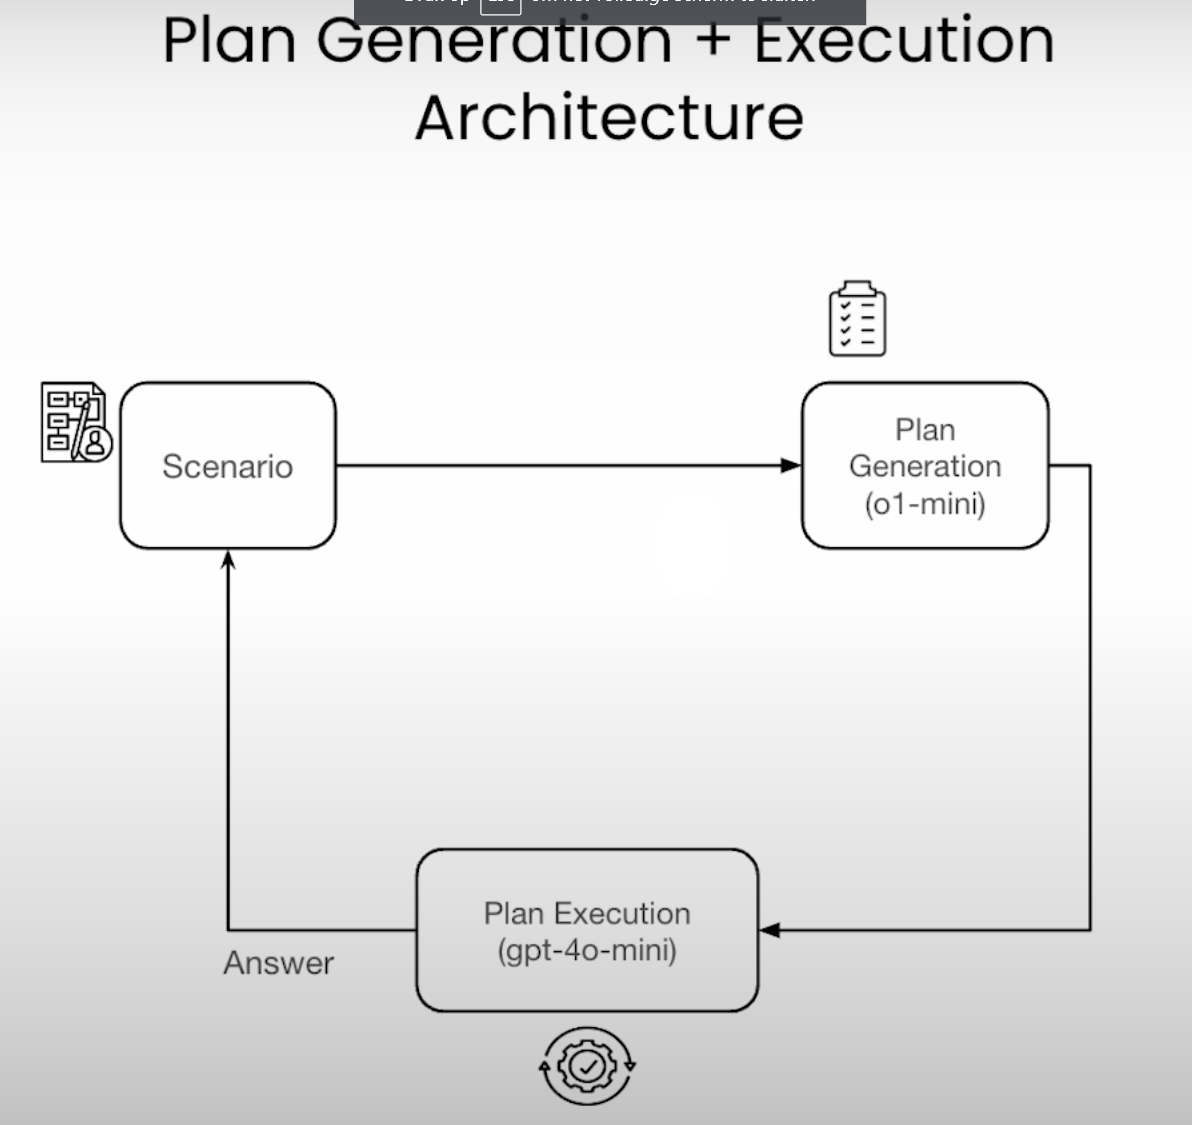

In [1]:
import os
from openai import OpenAI
from dotenv import load_dotenv  
import json
from IPython.display import display, Markdown, HTML
import copy
import json
from utils import o1_tools

In [2]:
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
client = OpenAI()
GPT_MODEL= 'gpt-4o-mini'
O1_MODEL= 'o1-mini'

In [4]:
# Initialize the message list
message_list = []

# Define the initial context for the application
context = {
    'inventory': {
        'X200': 50  # We currently have 50 units of Smart Home Hub X200 in stock
    },
    'orders': [
        {
            'order_id': 'ORD3001',
            'product_id': 'X200',
            'quantity': 200,
            'customer_id': 'CUST9001',
            'destination': 'Los Angeles',
            'weight': 1.5,  # Weight per unit in kg
            'dimensions': {'length': 20, 'width': 15, 'height': 10}  # Dimensions in cm
        }
    ],
    'available_suppliers': ['SUPP1001', 'SUPP1002'],
    'suppliers': {
        'SUPP1001': {
            'components': {
                'COMP_X200': {'available_quantity': 500}
            }
        },
        'SUPP1002': {
            'components': {
                'COMP_X300': {'available_quantity': 300}
            }
        }
    },
    'production_capacity': {
        'immediate': 100,      # Units we can produce immediately
        'next_week': 150       # Units we can produce next week
    },
    'shipping_options': {
        'Los Angeles': [
            {
                'carrier_id': 'CARRIER1',
                'service_level': 'Standard',
                'cost': 1000,
                'estimated_days': 5
            },
            {
                'carrier_id': 'CARRIER2',
                'service_level': 'Express',
                'cost': 1500,
                'estimated_days': 2
            }
        ]
    },
    'customers': {
        'CUST9001': {
            'name': 'ElectroWorld',
            'address': '123 Market Street, Los Angeles, CA'
        }
    },
    'products': {
        'X200': {
            'name': 'Smart Home Hub X200',
            'components_needed': {
                'COMP_X200': 1  # Each unit requires 1 component COMP_X200
            }
        }
    }
}

# Store the initial state of context
initial_context = copy.deepcopy(context)

In [5]:
# Prompt for the planning model
o1_prompt = """
You are a supply chain management assistant. The first input you will receive will be a complex task that needs to be carefully reasoned through to solve. 
Your task is to review the challenge, and create a detailed plan to process customer orders, manage inventory, and handle logistics.

You will have access to an LLM agent that is responsible for executing the plan that you create and will return results.

The LLM agent has access to the following functions:
    - get_inventory_status(product_id)
        - This gets the currently available product that we have
    - get_product_details(product_id)
        - This function gets the necessary components we need to manufacture additional product
    - update_inventory(product_id, quantity_change)
        - This function updates the currently available inventory of product.
        - This function should be called after we have allocated stock to an order.
    - fetch_new_orders()
        - The function checks the current status of new orders
    - allocate_stock(order_id, product_id, quantity)
        - This function allocates the stock of a product to an order.
    - check_available_suppliers()
        - This function checks the list of available suppliers we can leverage for additional components.
    - get_supplier_info(supplier_id)
        - This function returns the components the supplier can produce and the quantity of that component.
        - It is necessary to get the components required in order to place a purchase order with the supplier.
    - place_purchase_order(supplier_id, component_id, quantity)
        - This function places a purchase order with the supplier for additional components
        - In order to place the purchase order, we need to know the necessary components and the supplier id.
        - If the supplier specified does not have this component available, the function will fail.
    - check_production_capacity(time_frame)
        - Based on the amount of components we have, this function determines how much product we can produce on-site within a specific time-frame
        - If we do not have sufficient production capacity, a purchase order will need to be made to the supplier
    - schedule_production_run(product_id, quantity, time_frame)
        - This function convert the available production supply to product.
        - Any production scheduled will reduce the production capacity immediately available and available next week.
        - The time frame values can match the production capacity options: 'immediate' or 'next_week'
        - If a production run is scheduled with time frame 'immediate', it will automatically update our inventory with the new capacity. We should not call 'update_inventory' after.
    - calculate_shipping_options(destination, weight, dimensions)
        - This function determines the available shipping options and costs
        - Only currently available inventory can be shipped
        - Destination should match the destination name on the order
    - book_shipment(order_id, carrier_id, service_level)
        - This will book a shipment for a current order.
    - send_order_update(customer_id, order_id, message)
        - This will send an update to the customer and is necessary for any communications
        - It is important to keep customers in the loop about the status of the order

When creating a plan for the LLM to execute, break your instructions into a logical, step-by-step order, using the specified format:
    - **Main actions are numbered** (e.g., 1, 2, 3).
    - **Sub-actions are lettered** under their relevant main actions (e.g., 1a, 1b).
        - **Sub-actions should start on new lines**
    - **Specify conditions using clear 'if...then...else' statements** (e.g., 'If the product was purchased within 30 days, then...').
    - **For actions that require using one of the above functions defined**, write a step to call a function using backticks for the function name (e.g., `call the get_inventory_status function`).
        - Ensure that the proper input arguments are given to the model for instruction. There should not be any ambiguity in the inputs.
    - **The last step** in the instructions should always be calling the `instructions_complete` function. This is necessary so we know the LLM has completed all of the instructions you have given it.
    - **Detailed steps** The plan generated must be extremely detailed and thorough with explanations at every step.
Use markdown format when generating the plan with each step and sub-step.

Please find the scenario below.
"""

In [6]:
# System prompt for the execution model
gpt4o_system_prompt = """
You are a helpful assistant responsible for executing the policy on handling incoming orders. Your task is to follow the policy exactly as it is written and perform the necessary actions.

You must explain your decision-making process across various steps.

# Steps

1. **Read and Understand Policy**: Carefully read and fully understand the given policy on handling incoming orders.
2. **Identify the exact step in the policy**: Determine which step in the policy you are at, and execute the instructions according to the policy.
3. **Decision Making**: Briefly explain your actions and why you are performing them.
4. **Action Execution**: Perform the actions required by calling any relevant functions and input parameters.

POLICY:
{policy}

"""


In [7]:
TOOLS = [
    {
        "type": "function",
        "function": {
            "name": "get_inventory_status",
            "description": "Retrieves the current inventory status for a given product. This only shows the currently available inventory for PRODUCTS and not components.",
            "parameters": {
                "type": "object",
                "properties": {
                    "product_id": {
                        "type": "string",
                        "description": "The unique identifier for the product.",
                        "enum": ["X100", "X200", "X300"]
                    },
                },
                "required": ["product_id"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "update_inventory",
            "description": "Updates the inventory quantity for a specific product. This should be called after we have allocated stock to an order",
            "parameters": {
                "type": "object",
                "properties": {
                    "product_id": {
                        "type": "string",
                        "description": "The unique identifier for the product.",
                    },
                    "quantity_change": {
                        "type": "integer",
                        "description": "The amount to adjust the inventory by (positive or negative).",
                    },
                },
                "required": ["product_id", "quantity_change"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "fetch_new_orders",
            "description": "Fetches new customer orders that have not been processed yet. There are no input parameters for this function.",
            "parameters": {
                "type": "object",
                "properties": {},
                "required": [],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "check_available_suppliers",
            "description": "This functions checks the list of available suppliers we can leverage for additional components.",
            "parameters": {
                "type": "object",
                "properties": {},
                "required": [],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_product_details",
            "description": "Fetches the product details included the required components necessary for creating more of the product.",
            "parameters": {
                "type": "object",
                "properties": {
                    "product_id": {
                        "type": "string",
                        "description": "The unique identifier of the product.",
                    }
                },
                "required": ["product_id"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_supplier_info",
            "description": "This function returns the components the supplier can produce and the quantity of that component. It is necessary to get the components required in order to place a purchase order with the supplier.",
            "parameters": {
                "type": "object",
                "properties": {
                    "supplier_id": {
                        "type": "string",
                        "description": "The unique identifier of the supplier.",
                    }
                },
                "required": ["supplier_id"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "allocate_stock",
            "description": "Allocates stock for a specific order and product.",
            "parameters": {
                "type": "object",
                "properties": {
                    "order_id": {
                        "type": "string",
                        "description": "The unique identifier of the customer order.",
                    },
                    "product_id": {
                        "type": "string",
                        "description": "The unique identifier of the product.",
                    },
                    "quantity": {
                        "type": "integer",
                        "description": "The quantity of the product to allocate.",
                    },
                },
                "required": ["order_id", "product_id", "quantity"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "place_purchase_order",
            "description": "This function places a purchase order with the supplier for additional components. In order to place the purchase order, we need to know the necessary components and the supplier id. If the supplier specified does not have this component available, the function will fail.",
            "parameters": {
                "type": "object",
                "properties": {
                    "supplier_id": {
                        "type": "string",
                        "description": "The unique identifier of the supplier.",
                    },
                    "component_id": {
                        "type": "string",
                        "description": "The unique identifier of the component.",
                    },
                    "quantity": {
                        "type": "integer",
                        "description": "The quantity of the component to order.",
                    },
                },
                "required": ["supplier_id", "component_id", "quantity"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "check_production_capacity",
            "description": "Based on the amount of components we have, this function determines how much product we can produce on-site within a specific time-frame. If we do not have sufficient production capacity, a purchase order will need to be made to the supplier",
            "parameters": {
                "type": "object",
                "properties": {
                    "time_frame": {
                        "type": "string",
                        "description": "The time frame to check,",
                        "enum": ["immediate", "next_week"]
                    },
                },
                "required": ["time_frame"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "schedule_production_run",
            "description": "This function convert the available production supply to product. Any production scheduled will reduce the production capacity immedatiely available and available next week. If the quantity exceeds the immediately available production, it will fail. If a production run is scheduled with time frame 'immediate', it will automatically update our inventory with the new capacity.",
            "parameters": {
                "type": "object",
                "properties": {
                    "product_id": {
                        "type": "string",
                        "description": "The unique identifier of the product.",
                    },
                    "quantity": {
                        "type": "integer",
                        "description": "The quantity of the product to produce.",
                    },
                    "time_frame": {
                        "type": "string",
                        "description": "The time frame for when the production run needs to be scheduled.",
                        "enum": ["immediate", "next_week"]
                    },
                },
                "required": ["product_id", "quantity", "time_frame"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "calculate_shipping_options",
            "description": "This function determines the availablwe shipping options and costs. Only currently available inventory can be shipped",
            "parameters": {
                "type": "object",
                "properties": {
                    "destination": {
                        "type": "string",
                        "description": "The shipping destination address.",
                    },
                    "weight": {
                        "type": "number",
                        "description": "The weight of the package in kilograms.",
                    },
                    "dimensions": {
                        "type": "string",
                        "description": "The dimensions of the package (LxWxH) in centimeters.",
                    },
                },
                "required": ["destination", "weight", "dimensions"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "book_shipment",
            "description": "Books a shipment for an order using a specific carrier and service level.",
            "parameters": {
                "type": "object",
                "properties": {
                    "order_id": {
                        "type": "string",
                        "description": "The unique identifier of the customer order.",
                    },
                    "carrier_id": {
                        "type": "string",
                        "description": "The unique identifier of the shipping carrier.",
                    },
                    "service_level": {
                        "type": "string",
                        "description": "The level of shipping service, e.g., 'Standard', 'Express'.",
                    },
                },
                "required": ["order_id", "carrier_id", "service_level"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "send_order_update",
            "description": "This will send an update to the customer and is necessary for any communincations. It is important to keep customers in the loop about the status of the order",
            "parameters": {
                "type": "object",
                "properties": {
                    "customer_id": {
                        "type": "string",
                        "description": "The unique identifier of the customer.",
                    },
                    "order_id": {
                        "type": "string",
                        "description": "The unique identifier of the order.",
                    },
                    "message": {
                        "type": "string",
                        "description": "The message content to send to the customer.",
                    },
                },
                "required": ["customer_id", "order_id", "message"],
                "additionalProperties": False,
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "instructions_complete",
            "description": "Function should be called when we have completed ALL of the instructions.",
        },
    }
]

In [8]:
# Function Definitions
def get_inventory_status(product_id):
    quantity = context['inventory'].get(product_id, 0)
    return {'product_id': product_id, 'quantity': quantity}

def get_product_details(product_id):
    product = context['products'].get(product_id, {})
    return {"name": product.get('name', ''), "components_needed": product.get("components_needed", {})}

def update_inventory(product_id, quantity_change):
    if product_id not in context['inventory']:
        return {'error': f"Product ID {product_id} not found in inventory."}
    
    new_quantity = context['inventory'][product_id] + int(quantity_change)
    
    if new_quantity < 0:
        return {'error': 'Resulting inventory cannot be negative.'}
    
    context['inventory'][product_id] = new_quantity
    return {'product_id': product_id, 'new_quantity': new_quantity}

def fetch_new_orders():
    return context['orders'][0]

def allocate_stock(order_id, product_id, quantity):
    available = context['inventory'].get(product_id, 0)
    if available >= quantity:
        context['inventory'][product_id] -= quantity
        return {'order_id': order_id, 'allocated_quantity': quantity}
    else:
        allocated_quantity = available
        context['inventory'][product_id] = 0
        return {
            'order_id': order_id,
            'allocated_quantity': allocated_quantity,
            'error': 'Insufficient stock'
        }

def check_available_suppliers():
    available_suppliers = context['available_suppliers']
    return {"available_suppliers": available_suppliers}

def get_supplier_info(supplier_id):
    supplier = context['suppliers'].get(supplier_id)
    if not supplier:
        return {'error': f"Supplier {supplier_id} not found."}
    
    components = supplier.get('components', {})
    return {'supplier_id': supplier_id, 'components': components}

def place_purchase_order(supplier_id, component_id, quantity):
    supplier = context['suppliers'].get(supplier_id)
    if not supplier:
        return {'error': f"Supplier {supplier_id} not found."}
    component = supplier['components'].get(component_id)
    if not component:
        return {'error': f"Component {component_id} not found with supplier {supplier_id}."}
    if component['available_quantity'] < quantity:
        return {'error': f"Insufficient component quantity available from supplier {supplier_id}."}
    component['available_quantity'] -= quantity
    po_number = f"PO_{supplier_id}_{component_id}"
    context['production_capacity']['next_week'] += quantity
    
    return {'po_number': po_number, 'status': 'Placed'}

def check_production_capacity(time_frame):
    capacity = context['production_capacity'].get(time_frame, 0)
    return {'time_frame': time_frame, 'available_capacity': capacity}

def schedule_production_run(product_id, quantity, time_frame):
    capacity = context['production_capacity'].get(time_frame, 0)
    if capacity >= quantity:
        context['production_capacity'][time_frame] -= quantity
        if time_frame == 'immediate':
            context['inventory'][product_id] += quantity
        return {'production_id': 'PROD1001', 'status': 'Scheduled', 'time_frame': time_frame}
    else:
        return {'error': 'Insufficient production capacity, please order more from supplier.'}

def calculate_shipping_options(destination, weight, dimensions):
    options = context['shipping_options'].get(destination)
    if not options:
        return {'error': f"No shipping options available for destination {destination}."}
    return options

def book_shipment(order_id, carrier_id, service_level):
    tracking_number = f'TRACK_{order_id}'
    return {'tracking_number': tracking_number, 'status': 'Booked'}

def send_order_update(customer_id, order_id, message):
    return {'customer_id': customer_id, 'order_id': order_id, 'message_sent': True}

# Map function names to actual functions
function_mapping = {
    'get_inventory_status': get_inventory_status,
    'get_product_details': get_product_details,
    'update_inventory': update_inventory,
    'fetch_new_orders': fetch_new_orders,
    'allocate_stock': allocate_stock,
    'place_purchase_order': place_purchase_order,
    'check_available_suppliers': check_available_suppliers,
    'get_supplier_info': get_supplier_info,
    'check_production_capacity': check_production_capacity,
    'schedule_production_run': schedule_production_run,
    'calculate_shipping_options': calculate_shipping_options,
    'book_shipment': book_shipment,
    'send_order_update': send_order_update
}


In [9]:
def process_scenario(scenario):
    append_message({'type': 'status', 'message': 'Generating plan...'})

    plan = call_o1(scenario)

    append_message({'type': 'plan', 'content': plan})

    append_message({'type': 'status', 'message': 'Executing plan...'})

    messages = call_gpt4o(plan)

    append_message({'type': 'status', 'message': 'Processing complete.'})

    return messages

In [10]:
def append_message(message):
    message_list.append(message)
    # Optionally, print the message for immediate feedback
    message_type = message.get('type', '')
    if message_type == 'status':
        print(message['message'])
    elif message_type == 'plan':
        print("\nPlan:\n", message['content'])
    elif message_type == 'assistant':
        print("\nAssistant:\n", message['content'])
    elif message_type == 'function_call':
        print(f"\nFunction call: {message['function_name']} with arguments {message['arguments']}")
    elif message_type == 'function_response':
        print(f"\nFunction response for {message['function_name']}: {message['response']}")
    else:
        # Handle any other message types or default case
        print(message.get('content', ''))

In [11]:
def append_message(message):
    message_list.append(message)
    # Optionally, print the message for immediate feedback
    message_type = message.get('type', '')
    if message_type == 'status':
        print(message['message'])
    elif message_type == 'plan':
        print("\nPlan:\n", message['content'])
    elif message_type == 'assistant':
        print("\nAssistant:\n", message['content'])
    elif message_type == 'function_call':
        print(f"\nFunction call: {message['function_name']} with arguments {message['arguments']}")
    elif message_type == 'function_response':
        print(f"\nFunction response for {message['function_name']}: {message['response']}")
    else:
        # Handle any other message types or default case
        print(message.get('content', ''))

In [12]:
def call_o1(scenario):
    prompt = f"""
{o1_prompt}
    
Scenario:
{scenario}

Please provide the next steps in your plan."""
    
    response = client.chat.completions.create(
        model=O1_MODEL,
        messages=[{'role': 'user', 'content': prompt}]
    )
    plan = response.choices[0].message.content
    
    return plan

In [13]:
def call_gpt4o(plan):
    gpt4o_policy_prompt = gpt4o_system_prompt.replace("{policy}", plan)
    messages = [
        {'role': 'system', 'content': gpt4o_policy_prompt},
    ]

    while True:
        response = client.chat.completions.create(
            model=GPT_MODEL,
            messages=messages,
            tools=TOOLS,
            parallel_tool_calls=False
        )
        
        assistant_message = response.choices[0].message.to_dict()
        print(assistant_message)
        messages.append(assistant_message)

        append_message({'type': 'assistant', 'content': assistant_message.get('content', '')})

        if (response.choices[0].message.tool_calls and
            response.choices[0].message.tool_calls[0].function.name == 'instructions_complete'):
            break

        if not response.choices[0].message.tool_calls:
            continue

        for tool in response.choices[0].message.tool_calls:
            tool_id = tool.id
            function_name = tool.function.name
            input_arguments_str = tool.function.arguments

            append_message({'type': 'tool_call', 'function_name': function_name, 'arguments': input_arguments_str})

            try:
                input_arguments = json.loads(input_arguments_str)
            except (ValueError, json.JSONDecodeError):
                continue

            if function_name in function_mapping:
                try:
                    function_response = function_mapping[function_name](**input_arguments)
                except Exception as e:
                    function_response = {'error': str(e)}
            else:
                function_response = {'error': f"Function '{function_name}' not implemented."}

            try:
                serialized_output = json.dumps(function_response)
            except (TypeError, ValueError):
                serialized_output = str(function_response)

            messages.append({
                "role": "tool",
                "tool_call_id": tool_id,
                "content": serialized_output
            })

            append_message({'type': 'tool_response', 'function_name': function_name, 'response': serialized_output})

    return messages

In [14]:
# Example usage
scenario_text = ("We just received a major shipment of new orders. "
                 "Please generate a plan that gets the list of awaiting "
                 "orders and determines the best policy to fulfill them.\n\n"
                 "The plan should include checking inventory, ordering "
                 "necessary components from suppliers, scheduling production "
                 "runs with available capacity, ordering new components "
                 "required from suppliers, and arranging shipping to the "
                 "retailer’s distribution center in Los Angeles. Notify "
                 "the customer before completing.\n\n"
                 "Prioritize getting any possible orders out that you can "
                 "while placing orders for any backlog items.")

# Process the scenario
messages = process_scenario(scenario_text)

Generating plan...

Plan:
 ```markdown
# Order Fulfillment Plan

## 1. Retrieve and Assess New Orders
   a. `fetch_new_orders()`
      - Retrieve the list of all new orders awaiting fulfillment.
   b. For each order in the fetched list:
      i. Extract `order_id`, `customer_id`, `product_id`, `quantity`, and `destination`.

## 2. Check Inventory Status for Each Order
   a. For each `order_id`:
      i. `get_inventory_status(product_id)`
         - Retrieve the current available inventory for the specified `product_id`.
      ii. If `available_inventory >= quantity` then:
         - Proceed to allocate stock.
      iii. Else:
         - Mark order as needing additional inventory and proceed to Step 3.

## 3. Allocate Available Stock to Orders
   a. For orders where inventory is sufficient:
      i. `allocate_stock(order_id, product_id, quantity)`
         - Allocate the required quantity of the product to the order.
      ii. `update_inventory(product_id, -quantity)`
         - Update 

In [15]:
for x in messages:
    print(x)
    print('\n\n')

{'role': 'system', 'content': '\nYou are a helpful assistant responsible for executing the policy on handling incoming orders. Your task is to follow the policy exactly as it is written and perform the necessary actions.\n\nYou must explain your decision-making process across various steps.\n\n# Steps\n\n1. **Read and Understand Policy**: Carefully read and fully understand the given policy on handling incoming orders.\n2. **Identify the exact step in the policy**: Determine which step in the policy you are at, and execute the instructions according to the policy.\n3. **Decision Making**: Briefly explain your actions and why you are performing them.\n4. **Action Execution**: Perform the actions required by calling any relevant functions and input parameters.\n\nPOLICY:\n```markdown\n# Order Fulfillment Plan\n\n## 1. Retrieve and Assess New Orders\n   a. `fetch_new_orders()`\n      - Retrieve the list of all new orders awaiting fulfillment.\n   b. For each order in the fetched list:\n  